<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Modelo de Detecção de Fraude
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> </i> 
</p>  

# <font color='orange' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid orange;'>

In [67]:

## Bibliotecas de Análise de Dados
import pandas as pd 
import builtins as builtins
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random

# Bibliotecas de Seleção de Modelos
from skopt import BayesSearchCV

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score


# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

In [68]:
def plota_barras(variaveis, df, titulo, rotation=0, figsize=(8,5), top_n=None):
    if isinstance(variaveis, (list, tuple)):
        if len(variaveis) == 0:
            raise ValueError("lista de variáveis vazia")
        if len(variaveis) > 1:
            for v in variaveis:
                plota_barras(v, df, f"{titulo} — {v}", rotation=rotation, figsize=figsize, top_n=top_n)
            return
        variavel = variaveis[0]
    else:
        variavel = variaveis

    counts = df[variavel].value_counts()
    if top_n is not None:
        counts = counts.head(top_n)

    order = counts.index
    values = counts.values
    total = values.sum()

    ax = sns.barplot(x=order, y=values, color='#1FB3E5')

    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel(variavel, fontsize=12)
    ax.set_ylabel('Quantidade', fontsize=12)

    # Adiciona os percentuais em cima das barras
    for i, v in enumerate(values):
        ax.text(
            i,                     # posição X
            v + (max(values) * 0.01),  # posição Y (1% acima da barra)
            f'{(v/total)*100:.2f}%',  # texto
            ha='center', va='bottom', fontsize=10
        )

    ax.set_ylim(0, max(values) * 1.15)  # mais espaço pro texto
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)

    plt.tight_layout()
    plt.show()


def plota_boxplot(df, variavel, target):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=target, y=variavel, data=df, palette=['green', 'yellow', 'red'])
    plt.title(f'Boxplot Risco de Fraude para {variavel}', fontsize=12)
    plt.xlabel(target)
    plt.ylabel(variavel)

    # Ajuste da disposição dos gráficos
    plt.tight_layout()
    plt.show()



def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(8, 5))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.ylim(0, 20)
        plt.tight_layout()
        plt.show()

def plot_fraude(df, group_col, figsize=(18,4), cmap="RdYlGn_r"):
    # Agrupamento e cálculo
    df_group = (
        df.groupby(group_col, as_index=False)
          .agg({'transacao':'count', 'risk_transaction':'sum'})
          .rename(columns={'transacao':'qtd', 'risk_transaction':'fraude'})
    )
    df_group['%fraude'] = df_group['fraude'] / df_group['qtd'] * 100

    # Normaliza os valores de %fraude entre 0 e 1 para o colormap
    norm = mcolors.Normalize(vmin=df_group['%fraude'].min(), vmax=df_group['%fraude'].max())
    colors = cm.get_cmap(cmap)(norm(df_group['%fraude']))

    # Gráfico
    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_group,
        x=group_col,
        y='%fraude',
        palette=colors
    )
    plt.title(f'% Fraude por {group_col.capitalize()}', fontsize=16)
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('% Fraude', fontsize=12)

    # Inserindo rótulos nos valores
    for index, row in df_group.iterrows():
        plt.text(
            index, 
            row['%fraude'] + 0.2, 
            f"{row['%fraude']:.1f}", 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color='black'
        )

    # Barra de cores como legenda
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=0.01)
    cbar.set_label('% Fraude (escala de cor)', fontsize=12)

    plt.tight_layout()
    plt.show()
    
    return df_group

In [22]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]

    return x, y


def separa_treino_validacao_teste(target, dados, size_valid=0.1, size_test=0.2):
    x = dados.drop(target, axis=1)
    y = dados[target]
    # Primeiro separa teste
    x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=size_test, random_state=42)
    # Depois separa validação do restante
    x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=size_valid, random_state=42)

    df_train = pd.concat([y_train, x_train], axis=1)
    df_valid = pd.concat([y_valid, x_valid], axis=1)
    df_test = pd.concat([y_test, x_test], axis=1)

    return df_train, df_valid, df_test

In [23]:
def analisa_distribuicao_via_percentis(df, variaveis):
    def sublinha_percentis(s):
        is_1_percentile = s.name == '1%'
        is_99_8_percentile = s.name == '99%'
        if is_1_percentile or is_99_8_percentile:
            return ['background-color: blue'] * len(s)
        else:
            return [''] * len(s)

    percentis = df[variaveis].describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).style.apply(sublinha_percentis, axis=1)    

    return percentis

In [24]:
def compara_medias_amostras(df, variaveis_continuas, target="risk_transaction"):
    num_variaveis = len(variaveis_continuas)
    num_pares = (num_variaveis + 1) // 2  # Número de pares de variáveis para subplots
    fig, axes = plt.subplots(num_pares, 2, figsize=(14, 4 * num_pares))

    if num_pares == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_pares):
        if 2 * i < num_variaveis:
            variavel1 = variaveis_continuas[2 * i]
            percentis1 = df[variavel1].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_1 = percentis1['1%']
            p99_1 = percentis1['99%']
            df_raw1 = df.loc[(df[variavel1] > p1_1) & (df[variavel1] < p99_1)].copy()
            df_com_risk_transaction1 = df_raw1.loc[df_raw1[target] == 1]
            df_sem_risk_transaction1 = df_raw1.loc[df_raw1[target] == 0]

            medias_amostrais_com_risk_transaction1 = []
            medias_amostrais_sem_risk_transaction1 = []

            for j in range(5000):
                amostra_risk_transaction1 = random.choices(df_com_risk_transaction1[variavel1].values, k=1000)
                media_amostra_risk_transaction1 = np.mean(amostra_risk_transaction1)
                medias_amostrais_com_risk_transaction1.append(media_amostra_risk_transaction1)

                amostra_sem_risk_transaction1 = random.choices(df_sem_risk_transaction1[variavel1].values, k=1000)
                media_amostra_sem_risk_transaction1 = np.mean(amostra_sem_risk_transaction1)
                medias_amostrais_sem_risk_transaction1.append(media_amostra_sem_risk_transaction1)

            ax_hist1 = axes[i, 0]
            ax_hist1.hist(medias_amostrais_com_risk_transaction1, bins=30, alpha=0.5, label='risk_transaction', linewidth=5, color="red")
            ax_hist1.hist(medias_amostrais_sem_risk_transaction1, bins=30, alpha=0.5, label='Sem risk_transaction', linewidth=5, color="green")
            ax_hist1.legend(loc='upper right')
            ax_hist1.set_xlabel('Valores')
            ax_hist1.set_ylabel('Frequência')
            ax_hist1.set_title(f'Distribuição das Médias Amostrais de "{variavel1}" ')
            ax_hist1.grid(True)

        if 2 * i + 1 < num_variaveis:
            variavel2 = variaveis_continuas[2 * i + 1]
            percentis2 = df[variavel2].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_2 = percentis2['1%']
            p99_2 = percentis2['99%']
            df_raw2 = df.loc[(df[variavel2] > p1_2) & (df[variavel2] < p99_2)].copy()
            df_com_risk_transaction2 = df_raw2.loc[df_raw2[target] == 1]
            df_sem_risk_transaction2 = df_raw2.loc[df_raw2[target] == 0]

            medias_amostrais_com_risk_transaction2 = []
            medias_amostrais_sem_risk_transaction2 = []

            for j in range(5000):
                amostra_risk_transaction2 = random.choices(df_com_risk_transaction2[variavel2].values, k=1000)
                media_amostra_risk_transaction2 = np.mean(amostra_risk_transaction2)
                medias_amostrais_com_risk_transaction2.append(media_amostra_risk_transaction2)

                amostra_sem_risk_transaction2 = random.choices(df_sem_risk_transaction2[variavel2].values, k=1000)
                media_amostra_sem_risk_transaction2 = np.mean(amostra_sem_risk_transaction2)
                medias_amostrais_sem_risk_transaction2.append(media_amostra_sem_risk_transaction2)

            ax_hist2 = axes[i, 1]
            ax_hist2.hist(medias_amostrais_com_risk_transaction2, bins=30, alpha=0.5, label='risk_transaction', linewidth=5, color="red")
            ax_hist2.hist(medias_amostrais_sem_risk_transaction2, bins=30, alpha=0.5, label='Sem risk_transaction', linewidth=5, color="green")
            ax_hist2.legend(loc='upper right')
            ax_hist2.set_xlabel('Valores')
            ax_hist2.set_ylabel('Frequência')
            ax_hist2.set_title(f'Distribuição das Médias Amostrais de "{variavel2}" ')
            ax_hist2.grid(True)
        else:
            # Remove o subplot vazio se não houver segunda variável
            fig.delaxes(axes[i, 1])

    plt.tight_layout()
    plt.show()

In [25]:
def transform_to_deciles(df, variavel_continua):
    # Calcula os limites dos deciles
    decile_limits = [i / 10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
    
    # Aplica a função qcut para transformar a variável em deciles
    deciles = pd.qcut(df[variavel_continua], q=10, labels=False, duplicates='drop')
    
    return deciles

In [26]:
def woe(df, feature, target):

    epsilon = 1**-50  # Pequeno valor para evitar log(0)

    risk_transaction = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'risk_transaction'}, axis = 1)
    sem_risk_transaction = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'sem_risk_transaction'}, axis = 1)

    woe = risk_transaction.merge(sem_risk_transaction, on = feature, how = 'outer').fillna(0)
    woe['percent_risk_transaction'] = woe['risk_transaction']/woe['risk_transaction'].sum()
    woe['percent_sem_risk_transaction'] = woe['sem_risk_transaction']/woe['sem_risk_transaction'].sum()
    woe['woe'] = round(np.log((woe['percent_risk_transaction'] + epsilon)/(woe['percent_sem_risk_transaction'] + epsilon)), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    
    weight_of_evidence = woe['woe'].unique()


    x = list(woe[feature])
    y = list(woe['woe'])

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker='o', linestyle='--', linewidth=2, color='#1FB3E5')

    for label, value in zip(x, y):
        plt.text(x=label, y=value, s=str(value), fontsize=10, color='red', ha='left', va='center', rotation=45)

    plt.title(f'Weight of Evidence da variável "{feature}"', fontsize=14)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Weight of Evidence', fontsize=14)
    plt.xticks(ha='right', fontsize=10, rotation=45)
    plt.show()

In [27]:
def iv(df, feature, target):
    bad = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'bad'}, axis = 1)
    good = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'good'}, axis = 1)
    
    woe = good.merge(bad, on = feature, how = 'outer').fillna(0)
    woe['percent_bad'] = woe['bad']/woe['bad'].sum()
    woe['percent_good'] = woe['good']/woe['good'].sum()
    woe['woe'] = round(np.log(woe['percent_bad']/woe['percent_good']), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    woe['iv'] = ((woe['percent_bad'] - woe['percent_good'])*np.log(woe['percent_bad']/woe['percent_good'])).sum()

    woe['woe'].fillna(0, inplace = True)
    woe['iv'].fillna(0, inplace = True)

    weight_of_evidence = woe['woe'].unique()
    iv = round(woe['iv'].max(), 2)

    dicionario = {feature:iv}

    iv_df = pd.DataFrame(list(dicionario.items()), columns=['Feature', 'IV'])
    
    return iv_df

In [28]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]

    return x, y

def train_min_max_scaler(df):

    cols = list(df.drop(['id_registro', 'aprovado', 'mau'], axis = 1).columns)

    df_scaler = df[cols].copy()

    scaler = MinMaxScaler()
    scaler.fit(df_scaler)
    joblib.dump(scaler, "../models/scaler.pkl")
    print('Scaler Treinado e Salvo com sucesso!')

def Classificador(classificador, x_train, y_train, x_test, y_test, class_weight):

    # Puxa o Scaler Treinado com os dados de Treino
    scaler = joblib.load("../models/scaler.pkl")
    
    cols = list(x_train.drop(['id_registro', 'aprovado'], axis = 1).columns)

    x_train = x_train[cols]
    x_test = x_test[cols]

    # Define as colunas categóricas e numéricas
    models = {
        'Regressão Logística': make_pipeline(
            ColumnTransformer([
                ('scaler', make_pipeline(scaler), cols)
            ]),
            LogisticRegression(
                random_state=42, # Semente aleatória para reproducibilidade dos resultados
                class_weight={0: 1, 1: class_weight}, # Peso atribuído às classes. Pode ser útil para lidar com conjuntos de dados desbalanceados.
                C=1, # Parâmetro de regularização inversa. Controla a força da regularização.
                penalty='l2', # Tipo de regularização. 'l1', 'l2', 'elasticnet', ou 'none'.
                max_iter=50, # Número máximo de iterações para a convergência do otimizador.
                solver='liblinear' # Algoritmo de otimização. 'newton-cg', 'lbfgs', 'liblinear' (gradiente descendente), 'sag' (Stochastic gradient descent), 'saga' (Stochastic gradient descent que suporta reg L1).
                )
        )
    }

    if classificador in models:
        model = models[classificador]
    else:
        print('Utilize Regressão Logística, Random Forest ou XGBoost como opções de Classificadores!')

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    return model, y_pred_train, y_pred_test, y_proba_train, y_proba_test

def metricas_classificacao(classificador, y_train, y_predict_train, y_test, y_predict_test, y_predict_proba_train, y_predict_proba_test, etapa_1, etapa_2):

    predict_proba_train = pd.DataFrame(y_predict_proba_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_test = pd.DataFrame(y_predict_proba_test.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    # Treino
    accuracy_train = accuracy_score(y_train, y_predict_train)
    precision_train = precision_score(y_train, y_predict_train)
    recall_train = recall_score(y_train, y_predict_train)
    f1_train = f1_score(y_train, y_predict_train)
    roc_auc_train = roc_auc_score(y_train['mau'], predict_proba_train['predict_proba_1'])
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train['mau'], predict_proba_train['predict_proba_1'])
    ks_train = max(tpr_train - fpr_train)
    logloss_train = log_loss(y_train['mau'], predict_proba_train['predict_proba_1'])
    metricas_treino = pd.DataFrame(
        {
            'Acuracia': accuracy_train, 
            'Precisao': precision_train, 
            'Recall': recall_train, 
            'F1-Score': f1_train, 
            'AUC': roc_auc_train, 
            'KS': ks_train, 
            'LogLoss':logloss_train,
            'Etapa': etapa_1, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Teste
    accuracy_test = accuracy_score(y_test, y_predict_test)
    precision_test = precision_score(y_test, y_predict_test)
    recall_test = recall_score(y_test, y_predict_test)
    f1_test = f1_score(y_test, y_predict_test)
    roc_auc_test = roc_auc_score(y_test['mau'], predict_proba_test['predict_proba_1'])
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test['mau'], predict_proba_test['predict_proba_1'])
    ks_test = max(tpr_test - fpr_test)
    logloss_test = log_loss(y_test['mau'], predict_proba_test['predict_proba_1'])
    metricas_teste = pd.DataFrame(
        {
            'Acuracia': accuracy_test, 
            'Precisao': precision_test, 
            'Recall': recall_test, 
            'F1-Score': f1_test, 
            'AUC': roc_auc_test, 
            'KS': ks_test, 
            'LogLoss':logloss_test,
            'Etapa': etapa_2, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Consolidando
    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais


def metricas_classificacao_modelos_juntos(lista_modelos):
    if len(lista_modelos) > 0:
        metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
    else:
        metricas_modelos = lista_modelos[0]
    # Redefina o índice para torná-lo exclusivo
    df = metricas_modelos.reset_index(drop=True)
    df = df.round(2)

    # Função para formatar as células com base na Etapa
    def color_etapa(val):
        color = 'black'
        if val == 'treino':
            color = 'blue'
        elif val == 'teste':
            color = 'red'
        return f'color: {color}; font-weight: bold;'

    # Função para formatar os valores com até duas casas decimais
    def format_values(val):
        if isinstance(val, (int, float)):
            return f'{val:.2f}'
        return val

    # Estilizando o DataFrame
    styled_df = df.style\
        .format(format_values)\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
        .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
        .set_table_styles([
            {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
        ])

    # Mostrando o DataFrame estilizado
    styled_df
    return styled_df

# <font color='orange' style='font-size: 40px;'> 1. Leitura do Dataset </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset

# <font color='green' style='font-size: 30px;'> 1.1) Objetivos </font>
<hr style='border: 2px solid green;'>

### 1) Descrição

- Timestamp: Data e hora da transação.
- Hour of Day: Parte da hora no timestamp da transação.
- Sending Address: Endereço de blockchain do enviador.
- Receiving Address: Endereço de blockchain do recebedor.
- Amount: Valor da transação em uma moeda simulada.
- Transaction Type: Categoria da transação (por exemplo, transferência, venda, compra, golpe, phishing).
- Location Region: Região geográfica simulada da transação.
- IP Prefix: Prefixo de endereço IP simulado para a transação.
- Login Frequency: Frequência de sessões de login pelo usuário, variando por faixa etária.
- Session Duration: Duração das sessões de atividade em minutos.
- Purchase Pattern: Padrão comportamental de compras (por exemplo, focado, aleatório, de alto valor).
- Age Group: Classificação dos usuários como novos, estabelecidos e veteranos com base no histórico de atividade.
- Risk Score: Pontuação de risco calculada com base nas características da transação e no comportamento do usuário.
- Anomaly: Avaliação do nível de risco (por exemplo, alto_risco, risco_moderado, baixo_risco).

In [29]:
df_metaverse = pd.read_csv('./data/metaverse_transactions_dataset.csv')
df_metaverse = (
    df_metaverse
        .rename(
            columns=
            {
                'timestamp':'data_hora_transacao', 
                'hour_of_day':'hora_transacao', 
                'sending_address':'id_enviador', 
                'receiving_address':'id_recebedor',
                'amount':'valor_transacao', 
                'transaction_type':'tipo_transacao', 
                'location_region':'regiao_geografica', 
                'ip_prefix':'prefixo_ip',
                'login_frequency':'frequencia_login', 
                'session_duration':'duracao_sessao_atividade', 
                'purchase_pattern':'padrao_comportamental_de_compras', 
                'age_group':'recencia_atividade',
                'risk_score':'risk_score', 
                'anomaly':'risk_rank',
            }
        )
)

# Converter para datetime
df_metaverse['data_hora_transacao'] = pd.to_datetime(df_metaverse['data_hora_transacao'])
df_metaverse['ano'] = df_metaverse['data_hora_transacao'].dt.strftime('%Y')
df_metaverse['safra'] = df_metaverse['data_hora_transacao'].dt.strftime('%m')  # mês
df_metaverse['dia'] = df_metaverse['data_hora_transacao'].dt.strftime('%d')
df_metaverse['hora'] = df_metaverse['data_hora_transacao'].dt.strftime('%H')
df_metaverse['minuto'] = df_metaverse['data_hora_transacao'].dt.strftime('%M')
df_metaverse['segundo'] = df_metaverse['data_hora_transacao'].dt.strftime('%S')
df_metaverse['risk_transaction'] = np.where(df_metaverse['risk_rank'] == 'high_risk', 1, 0)
df_metaverse['transacao'] = 1
df_metaverse = (
    df_metaverse
        [[
            'ano', 'safra', 'dia', 'hora', 'minuto', 'segundo', 'data_hora_transacao', 'id_enviador','id_recebedor', 'transacao',
            'valor_transacao', 'tipo_transacao','regiao_geografica', 'prefixo_ip', 'frequencia_login',
            'duracao_sessao_atividade', 'padrao_comportamental_de_compras','recencia_atividade', 'risk_score', 'risk_rank', 'risk_transaction'
        ]]
        .sort_values(by = ['ano', 'safra', 'dia', 'hora', 'minuto', 'segundo', 'data_hora_transacao', 'id_enviador', 'id_recebedor'], ascending = True)
)

df_metaverse.head()

,ano,safra,dia,hora,minuto,segundo,data_hora_transacao,id_enviador,id_recebedor,transacao,valor_transacao,tipo_transacao,regiao_geografica,prefixo_ip,frequencia_login,duracao_sessao_atividade,padrao_comportamental_de_compras,recencia_atividade,risk_score,risk_rank,risk_transaction
62869,2022,01,01,00,00,45,2022-01-01 00:00:45,0x5e539dac6637b38aaf015861ec2da850f1ae8377,0x16c9903f99897fa292f3273513da8cf6525d0b06,1,592.02,transfer,South America,10.00,6,84,high_value,veteran,49.61,low_risk,0
41882,2022,01,01,00,12,24,2022-01-01 00:12:24,0xaaf2483f28bf10330253f83f9e016e1b900ad78b,0xa90b541bd2dfef162b82073318ace3fcc57340d9,1,755.50,transfer,North America,172.16,3,70,focused,established,25.31,low_risk,0
31457,2022,01,01,00,14,54,2022-01-01 00:14:54,0xccbf5a9926606c77db8391185066a8ee3bc0a2af,0x4f3070a2a31388c4897667752bbfac56d6426bb0,1,247.72,transfer,Asia,192.00,5,54,focused,established,20.25,low_risk,0
18364,2022,01,01,00,27,12,2022-01-01 00:27:12,0xffa670245089044b1e355508a7843692a25a5e52,0xc78a13e93a188c445584e724a855aeb94f972dd5,1,422.79,purchase,North America,172.16,4,62,focused,established,35.44,low_risk,0
3359,2022,01,01,00,36,27,2022-01-01 00:36:27,0xd92a3fafc71c2c3cde19665c9f46ec67638e33a1,0x55c98683de5bef9456cc9b82a87f0d8e942c7d6e,1,353.95,sale,South America,172.16,7,94,high_value,veteran,70.88,moderate_risk,0


# <font color='orange' style='font-size: 40px;'> 2. Análise da Target </font>
<hr style='border: 2px solid orange;'>

# <font color='green' style='font-size: 30px;'> 2.1) Target - Risk Score, Risk Rank e Risk Clients </font>
<hr style='border: 2px solid green;'>

> 1. Temos 80% dos casos como Baixo Risco, 11% como Risco Moderado e 8% como Alto Risco

> 2. O Baixo Risco vai do Score 0 ao 60; o Risco Moderado do Score 60 ao 75 (mais ou menos) e o Alto Risco do Score 75 pra cima

> 3. A distribuição de Clientes Arriscados é relativamente estável ao longo do tempo, sem mudanças muito abruptas

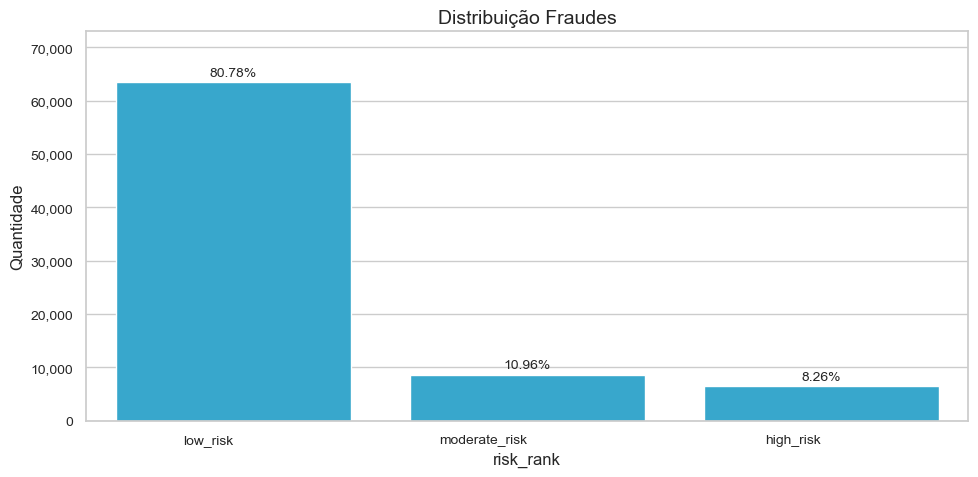

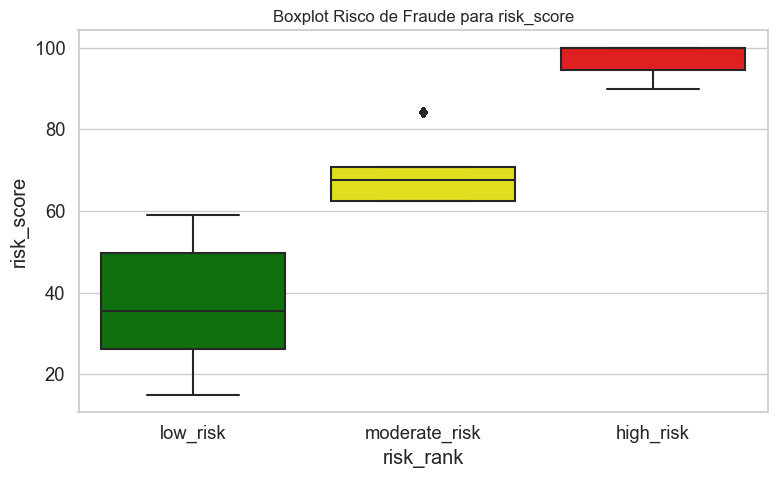

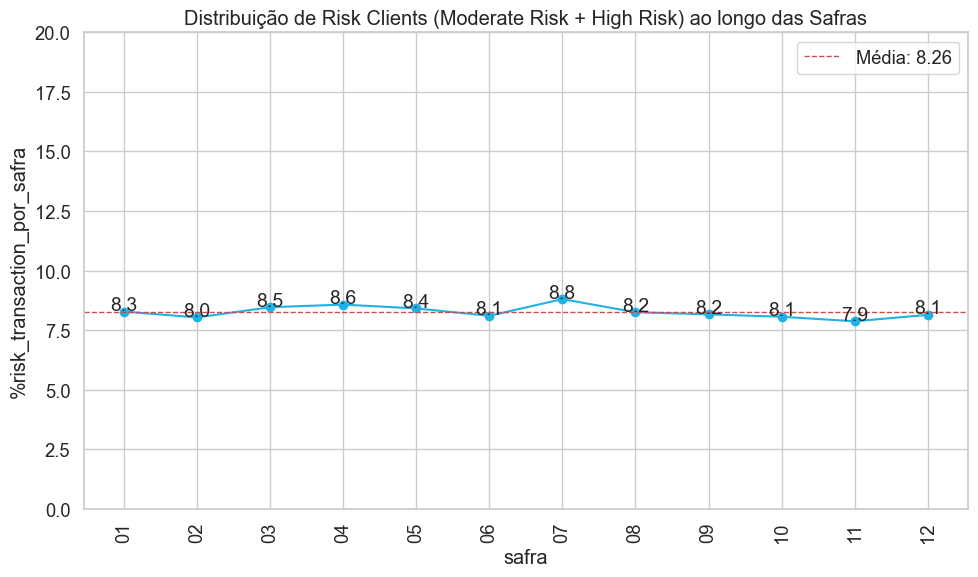

In [30]:
# Distribuição de Risk Rank
plota_barras(['risk_rank'], df_metaverse, 'Distribuição Fraudes', rotation=0)


# Risk Score vs Risk Rank
plota_boxplot(df_metaverse, 'risk_score', 'risk_rank')

# Risk Client Vs Safra
risk_transaction_por_safra = df_metaverse[["id_enviador", "safra", "risk_transaction"]].groupby("safra").agg({"risk_transaction":"sum", "id_enviador":"count"}).reset_index()
risk_transaction_por_safra["%risk_transaction_por_safra"] = round(risk_transaction_por_safra["risk_transaction"]/risk_transaction_por_safra["id_enviador"]*100, 2)
plota_grafico_linhas(risk_transaction_por_safra, "safra", "%risk_transaction_por_safra", False, "Distribuição de Risk Clients (Moderate Risk + High Risk) ao longo das Safras")

# <font color='green' style='font-size: 30px;'> 2.2) Separação de Amostras para Treino, Teste e OOT </font>
<hr style='border: 2px solid green;'>

> 1. Optou-se por definir como 1 as transações marcadas por Alto Risco e 0 como as de Moderado ou Baixo Risco

> 2. A ideia será treinar o Modelo com as safras 202201 até 202209 e testar com 202210, 202211 e 202212, com um Out-Of-Sample de 202201 até 202209

- Treino + Validação --> 80% dos IDs entre 202201 e 202209, sendo 90% para Treinamento do Modelo e 10% para Validação.
- Teste --> 20% dos IDs do treino
- OOT --> Todos os IDs para 201609

-  '202201' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202202' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202203' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202204' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202205' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202206' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202207' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202208' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202209' --> TREINAMENTO/VALIDAÇÃO/TESTE (Out-Of-Sample)
-  '202210' --> OOT (Out-Of-Time)
-  '202211' --> OOT (Out-Of-Time)
-  '202212' --> OOT (Out-Of-Time)


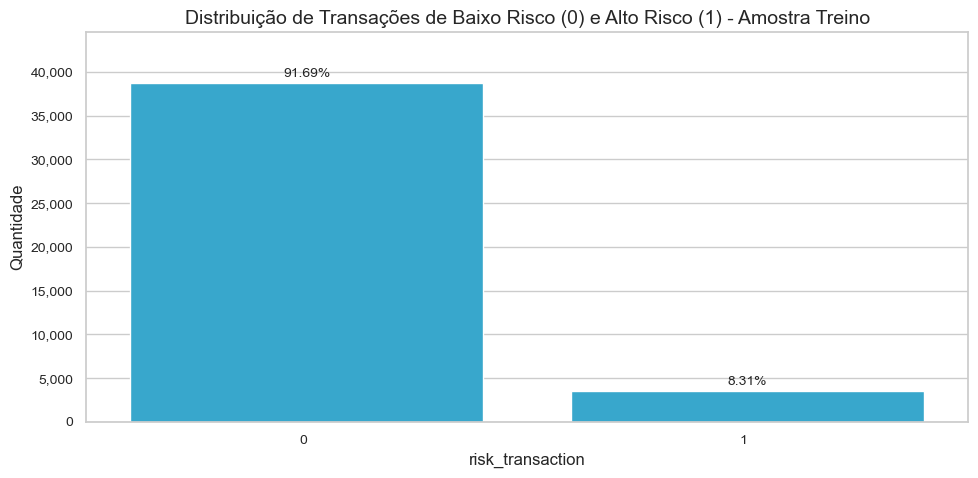

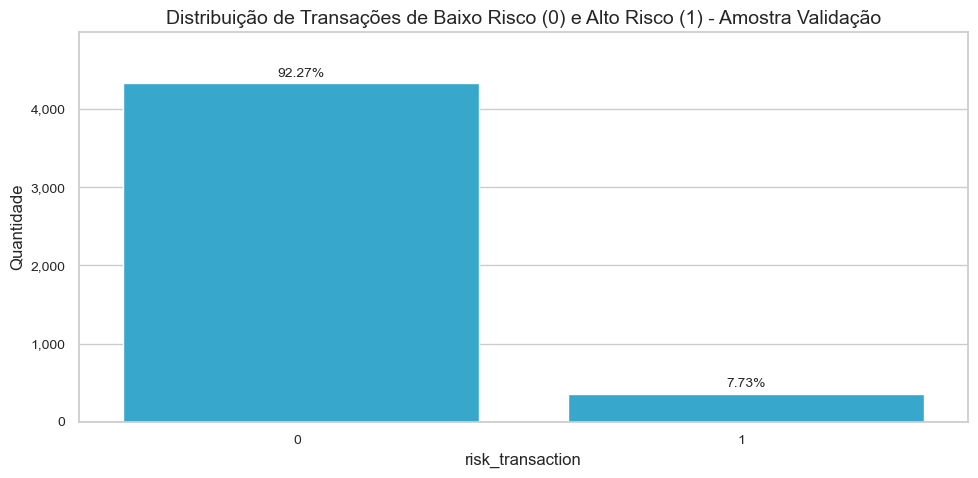

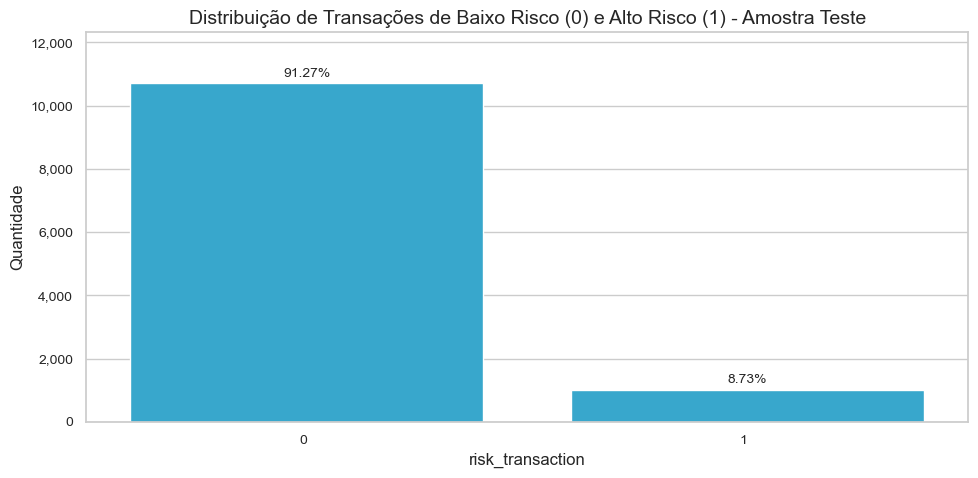

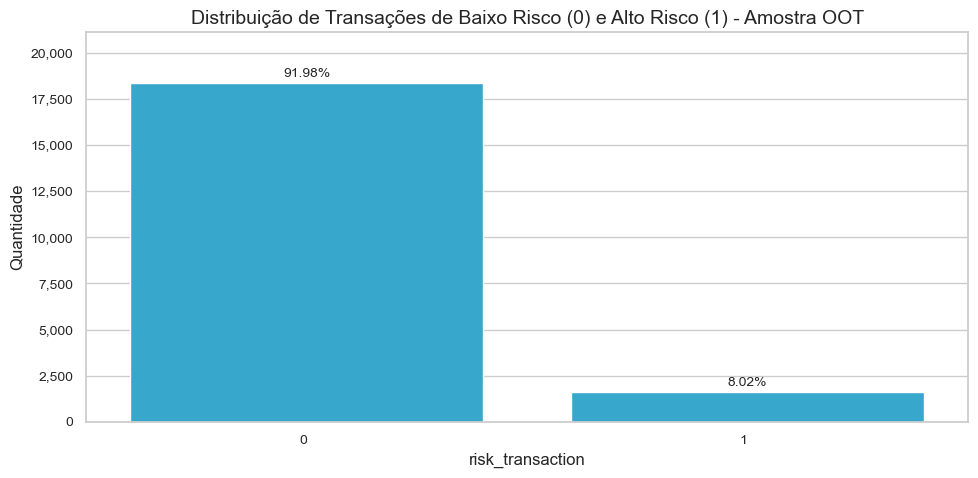

In [31]:
train_valid_test = df_metaverse.loc[~df_metaverse["safra"].isin(["10", "11", "12"])]
oot = df_metaverse.loc[df_metaverse["safra"].isin(["10", "11", "12"])]

df_train, df_valid, df_test = separa_treino_validacao_teste('risk_transaction', train_valid_test, size_valid=0.1, size_test=0.2)
df_oot = oot.copy()

amostras = [df_train, df_valid, df_test, df_oot]
tipo = ["Treino", "Validação", "Teste", "OOT"]
i = 0
for amostra in amostras:
    plota_barras(['risk_transaction'], amostra, f'Distribuição de Transações de Baixo Risco (0) e Alto Risco (1) - Amostra {tipo[i]}', 0)

    i = i + 1

# <font color='orange' style='font-size: 40px;'> 3. Análise Exploratória </font>
<hr style='border: 2px solid orange;'>

# <font color='green' style='font-size: 30px;'> 3.1) Tipo de Dados </font>
<hr style='border: 2px solid green;'>

In [32]:
target = ['risk_transaction']
key_cols = ['id_enviador', 'id_recebedor', 'risk_score', 'risk_rank']
timestamp_cols = ['ano', 'safra', 'dia', 'hora', 'minuto', 'segundo', 'data_hora_transacao']
num_cols = ['valor_transacao', 'prefixo_ip', 'frequencia_login', 'duracao_sessao_atividade']
cat_cols = ['tipo_transacao', 'regiao_geografica', 'padrao_comportamental_de_compras', 'recencia_atividade']

# <font color='green' style='font-size: 30px;'> 3.2) Nulos </font>
<hr style='border: 2px solid green;'>

Existem 21 variáveis no Dataset
Existem 21 variáveis sem registros nulos no Dataset


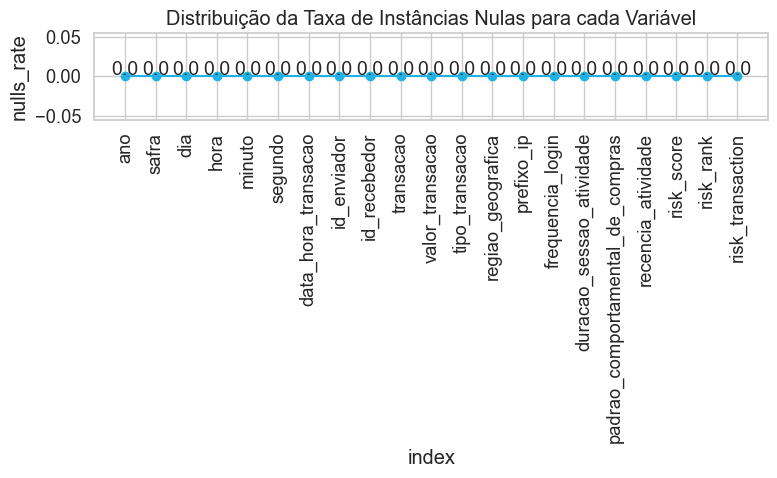

In [33]:
df_nulls = (
    pd.DataFrame(
        df_metaverse
        # .drop(["msno", "safra", "churn"] + variaveis_desconsideradas, axis = 1)
        .isnull().sum()
      )
      .reset_index()
      .rename({0:'nulls_amnt'}, axis = 1)
)
df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_metaverse.shape[0])*100, 2)

print(f'Existem {len(df_nulls)} variáveis no Dataset')
df_not_nulls_nulls = df_nulls.loc[df_nulls['nulls_rate'] == 0]
columns_not_nulls = list(df_not_nulls_nulls['index'])
print(f'Existem {len(columns_not_nulls)} variáveis sem registros nulos no Dataset')

plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")

# <font color='green' style='font-size: 30px;'> 3.3) Variáveis Numéricas </font>
<hr style='border: 2px solid green;'>

> 1. Não há valores muito discrepantes nas distribuições, a não ser transações de 1 centavo, o que  é estranho

> 2. Em média, tem-se a seguinte conclusão:

- As fraudes concentram-se em valores mais baixos, em operações únicas (frequências menores) e rápidas (duração mais baixa)
- O IP não aparenta discriminar a Fraude de maneira isolada

In [34]:
### Retirando amostras nulas para ver a distribuição
df_eda_continuas = df_train[num_cols].dropna().copy()
for col in df_eda_continuas[num_cols]:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x:float(x))

analisa_distribuicao_via_percentis(df_eda_continuas, num_cols)

,valor_transacao,prefixo_ip,frequencia_login,duracao_sessao_atividade
count,42234.000000,42234.000000,42234.000000,42234.000000
mean,502.210521,147.813896,4.180684,69.640953
std,245.848370,69.275415,2.368339,40.478092
min,0.010000,10.000000,1.000000,20.000000
1%,0.010000,10.000000,1.000000,20.000000
5%,89.112373,10.000000,1.000000,22.000000
10%,176.929074,10.000000,1.000000,25.000000
20%,288.553839,172.000000,2.000000,32.000000
30%,367.477747,172.000000,2.000000,38.000000
40%,436.329333,172.160000,3.000000,48.000000


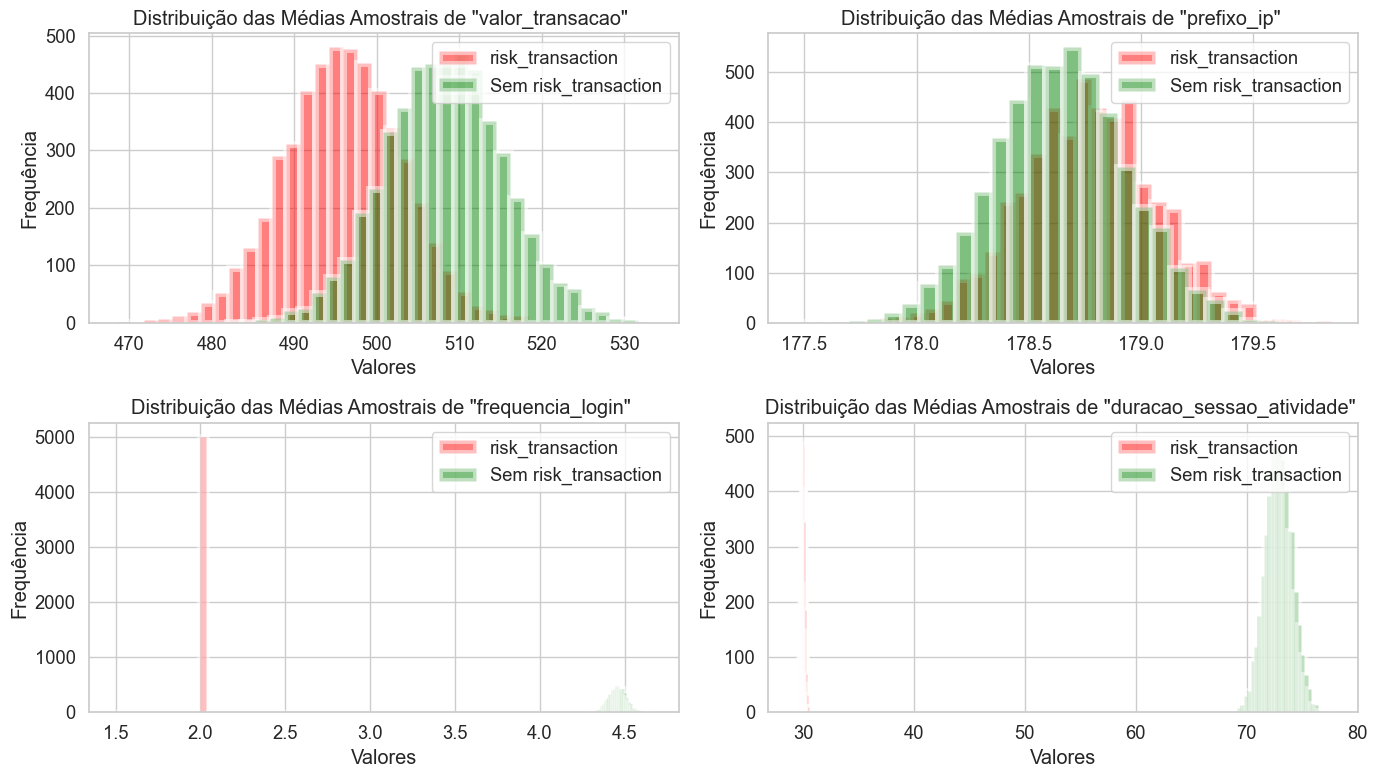

In [35]:
df_eda_continuas = df_train[num_cols + ["risk_transaction"]].dropna().copy()
for col in num_cols:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x: float(x))

compara_medias_amostras(df_eda_continuas, num_cols)

# <font color='green' style='font-size: 30px;'> 3.4) Variáveis Categóricas </font>
<hr style='border: 2px solid green;'>

> 1. O tipo de transação possui Data Leakage, pois só é possível saber a legitimidade de uma transação após a classificação a posteriori

> 2. A região geográfica pode ser utilizada e traz bons insights

> 3. As variáveis de padrão comportamental e recência atividade devem ser recriadas

In [36]:
df_eda_categoricas = df_train[cat_cols + ["risk_transaction"]].dropna().copy()
for col in df_eda_categoricas[cat_cols].columns:
    df_eda_categoricas[col] = df_eda_categoricas[col].apply(lambda x:str(x))
    risk_transaction = df_train.loc[df_train["risk_transaction"] == 1].groupby(col, as_index = False)["risk_transaction"].count().rename({"risk_transaction":'risk_transaction'}, axis = 1)
    sem_risk_transaction = df_train.loc[df_train["risk_transaction"] == 0].groupby(col, as_index = False)["risk_transaction"].count().rename({"risk_transaction":'sem_risk_transaction'}, axis = 1)
    distribuicao = risk_transaction.merge(sem_risk_transaction, on = col, how = 'outer').fillna(0)
    display(distribuicao)

,tipo_transacao,risk_transaction,sem_risk_transaction
0,phishing,1371.00,0.00
1,scam,2137.00,0.00
2,purchase,0.00,13287.00
3,sale,0.00,13526.00
4,transfer,0.00,11913.00


,regiao_geografica,risk_transaction,sem_risk_transaction
0,Africa,686,7661
1,Asia,722,7612
2,Europe,653,7835
3,North America,738,7892
4,South America,709,7726


,padrao_comportamental_de_compras,risk_transaction,sem_risk_transaction
0,random,3508.00,10514
1,focused,0.00,14021
2,high_value,0.00,14191


,recencia_atividade,risk_transaction,sem_risk_transaction
0,new,3508.00,10514
1,established,0.00,14021
2,veteran,0.00,14191


# <font color='green' style='font-size: 30px;'> 3.5) Variáveis Temporais </font>
<hr style='border: 2px solid green;'>

> 1. Não há um padrão claro em termos temporais para fraude, contudo, pode-se notar pequenas observações:

- Aparentemente as fraudes crescem a partir das 13h, mais especificamente no início, meio e final do mês (onde possivelmente existem mais transações dado o comportamento econômico das pessoas)
- Não é observado um padrão mensal em fraudes, portanto, descartou-se a possibilidade de haver sazonalidade mensal


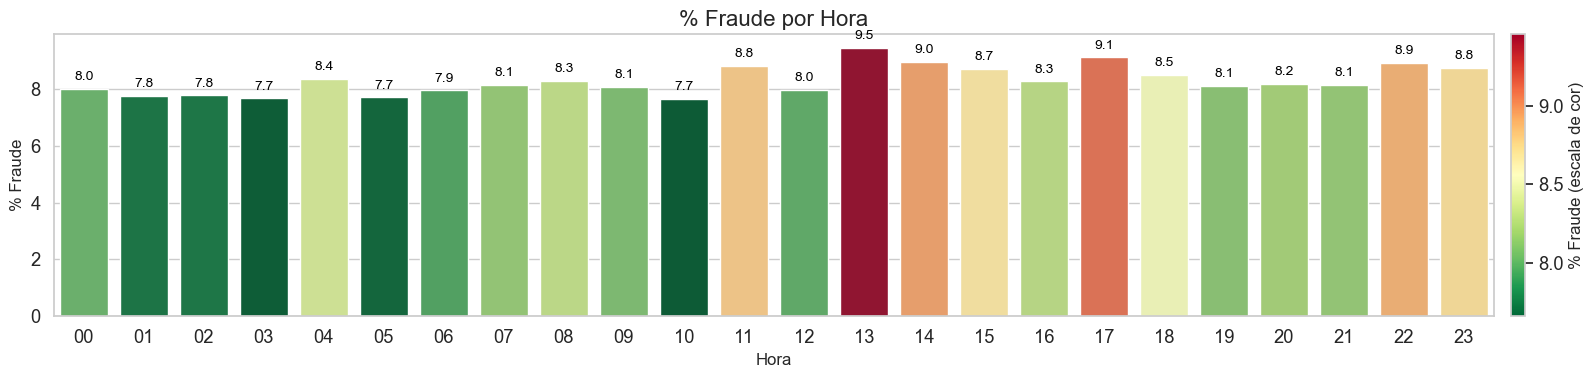

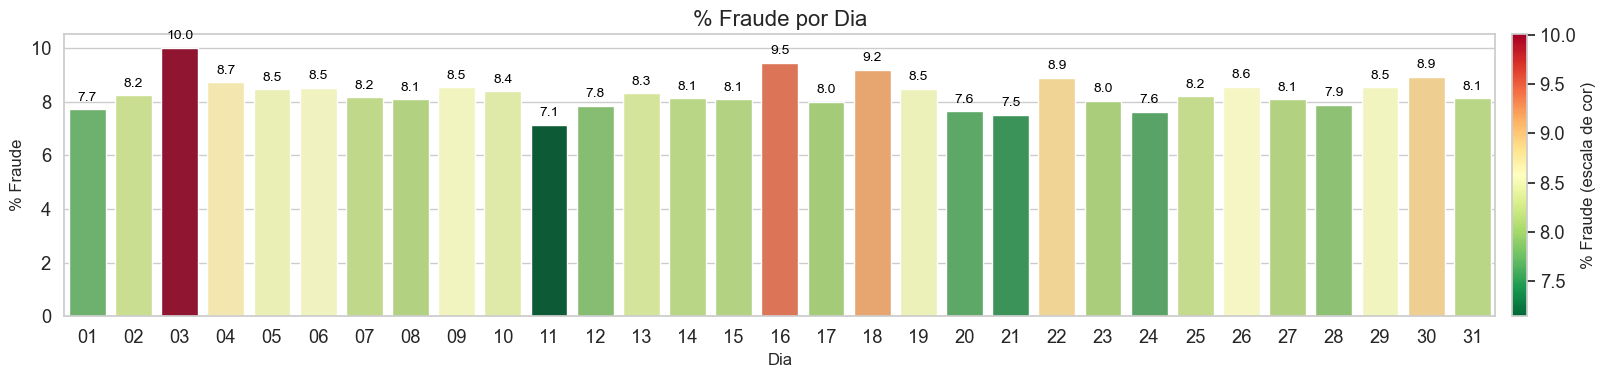

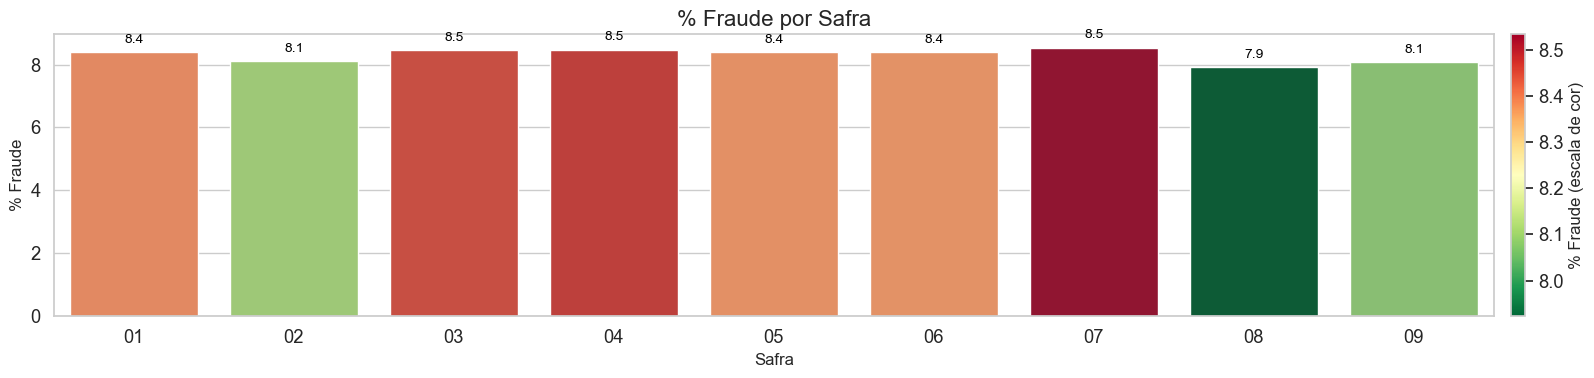

In [ ]:
df_hora  = plot_fraude(df_train, "hora")
df_dia   = plot_fraude(df_train, "dia")
df_safra = plot_fraude(df_train, "safra")

# <font color='orange' style='font-size: 40px;'> 4. Feature Engineering  </font>
<hr style='border: 2px solid orange;'>

#### A ideia será criar variáveis relacionadas ao Enviador e ao Recebedor e em relação à própria Transação em si a fim de verificar se a Transação tem maior ou menor probabilidade de ser uma Fraude

In [72]:
df_train.drop(['tipo_transacao', 'padrao_comportamental_de_compras', 'recencia_atividade'], axis=1, inplace=True)
df_valid.drop(['tipo_transacao', 'padrao_comportamental_de_compras', 'recencia_atividade'], axis=1, inplace=True)
df_test.drop(['tipo_transacao', 'padrao_comportamental_de_compras', 'recencia_atividade'], axis=1, inplace=True)
df_oot.drop(['tipo_transacao', 'padrao_comportamental_de_compras', 'recencia_atividade'], axis=1, inplace=True)

# <font color='green' style='font-size: 30px;'> 4.1) Variáveis de RFMV </font>
<hr style='border: 2px solid green;'>

> 1. Enviador Puro

- Quantidade de Dias desde a última transação (Recência)
- Quantidade de Transações realizadas até o momento (Frequência)
- Hora mais Frequente de Transação (Frequência)
- Dia mais Frequente de Transação (Frequência)
- Quantidade Média de Transações por Minuto (Frequência)
- Quantidade Média de Transações por Hora (Frequência)
- Quantidade Média de Duração da Sessão de Atividade (Frequência)
- Valor Máximo de Transação (Monetariedade)
- Valor Mínimo de Transação (Monetariedade)
- Valor Médio de Transação (Monetariedade)
- Valor Médio das últimas 3 transações (Monetariedade)
- Valor Médio das últimas 6 transações (Monetariedade)
- Desvio Padrão do Valor de Transações (Volatilidade)
- Desvio Padrão do Horário de Transações (Volatilidade)
- Tempo entre Transações Consecutivas (Volatilidade)
- Quantidade Total de Recebedores
- Quantidade Média de Recebedores

> 2. Recebedor Puro

- Quantidade de Dias desde a última transação (Recência)
- Quantidade de Transações realizadas até o momento (Frequência)
- Hora mais Frequente de Transação (Frequência)
- Dia mais Frequente de Transação (Frequência)
- Quantidade Média de Transações por Minuto (Frequência)
- Quantidade Média de Transações por Hora (Frequência)
- Quantidade Média de Duração da Sessão de Atividade (Frequência)
- Valor Máximo de Transação (Monetariedade)
- Valor Mínimo de Transação (Monetariedade)
- Valor Médio de Transação (Monetariedade)
- Valor Médio das últimas 3 transações (Monetariedade)
- Valor Médio das últimas 6 transações (Monetariedade)
- Desvio Padrão do Valor de Transações (Volatilidade)
- Desvio Padrão do Horário de Transações (Volatilidade)
- Tempo Médio entre Transações Consecutivas (Volatilidade)
- Quantidade Total de Enviadores
- Quantidade Média de Enviadores


> 3. Par Enviador e Recebedor

- Quantidade de Dias desde a última transação (Recência)
- Quantidade de Transações realizadas até o momento (Frequência)
- Hora mais Frequente de Transação (Frequência)
- Dia mais Frequente de Transação (Frequência)
- Quantidade Média de Transações por Minuto (Frequência)
- Quantidade Média de Transações por Hora (Frequência)
- Quantidade Média de Duração da Sessão de Atividade (Frequência)
- Valor Máximo de Transação (Monetariedade)
- Valor Mínimo de Transação (Monetariedade)
- Valor Médio de Transação (Monetariedade)
- Valor Médio das últimas 3 transações (Monetariedade)
- Valor Médio das últimas 6 transações (Monetariedade)
- Desvio Padrão do Valor de Transações (Volatilidade)
- Desvio Padrão do Horário de Transações (Volatilidade)
- Tempo entre Transações Consecutivas (Volatilidade)
- Percentual de Transações do Par em relação ao Total do Enviador
- Percentual de Transações do Par em relação ao Total do Recebedor
- Delta do Valor Transacionado do Par

> 4. Geográficas

- Migração de Região no mesmo minuto, hora e dia
- Migração de IP no mesmo minuto, hora e dia

> 5. Grafos

- Soma de Fraudes Presentes na Rede de Relacionamentos
- Quantidade Média de Arestas por Enviador até chegar a uma Fraude

> 6. Cadeia de Markov

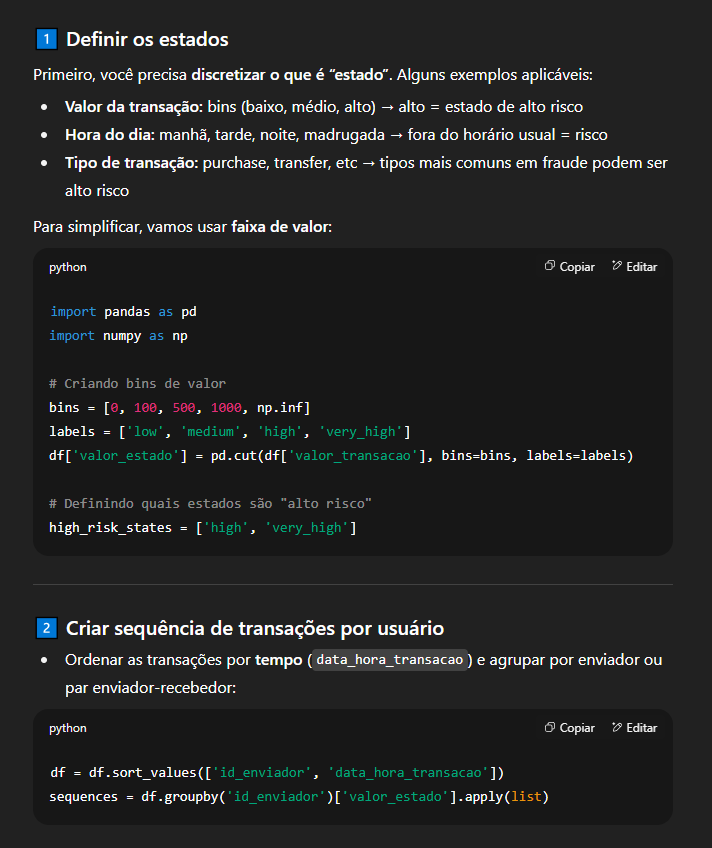
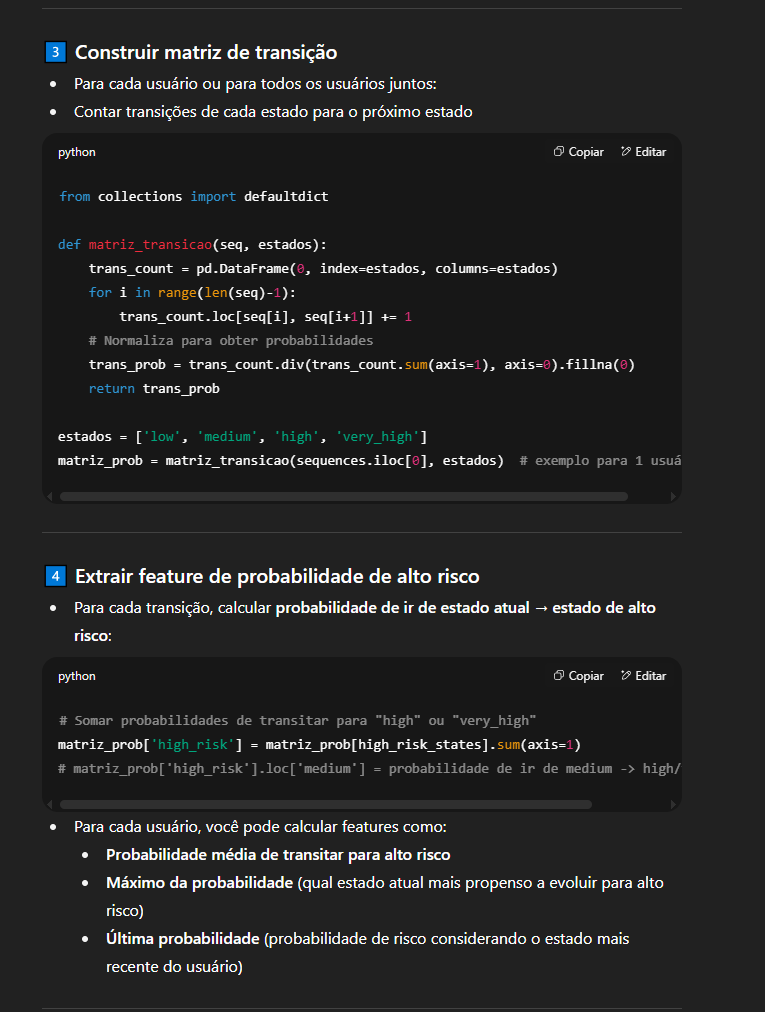
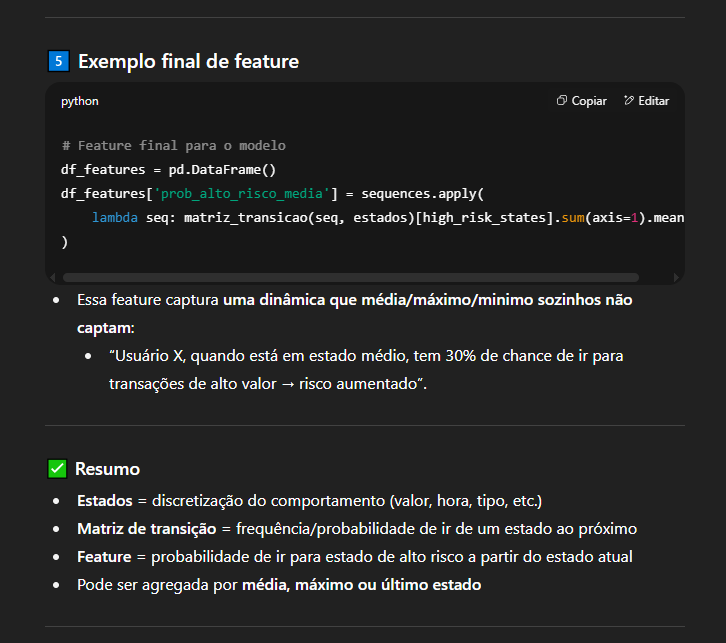


In [73]:
df_train.head()

,risk_transaction,ano,safra,dia,hora,minuto,segundo,data_hora_transacao,id_enviador,id_recebedor,transacao,valor_transacao,regiao_geografica,prefixo_ip,frequencia_login,duracao_sessao_atividade,risk_score,risk_rank
33736,0,2022,02,02,18,17,37,2022-02-02 18:17:37,0x901059fcd87816eafb17a388f083ec0a32d2258c,0xe55ae2851881b5a0a265ac25d88b34a80acdd7de,1,386.46,Asia,172.00,1,22,26.25,low_risk
73109,0,2022,08,14,14,06,49,2022-08-14 14:06:49,0xd4593947e9b1d5d503caf8ce90102967ac635593,0x927eb5472ae6124e561287052ba08e71b72ab8c5,1,598.28,Africa,192.17,7,119,52.50,low_risk
33,0,2022,01,01,14,21,36,2022-01-01 14:21:36,0xf0d6bebfc2d985fe3f46d2d9c04819ffb9e6d605,0xe4dda16590c1b05a186a0c0055914c056f037a05,1,483.40,North America,172.00,3,53,15.75,low_risk
14835,0,2022,07,26,16,37,24,2022-07-26 16:37:24,0xcc5669b7557c81295d0ae60e59d7daca070b3de5,0x26d5acc92d58460a18ad3d70ff1ccb23ea3a06aa,1,351.54,Africa,10.00,5,61,15.75,low_risk
20043,0,2022,04,02,19,52,06,2022-04-02 19:52:06,0xb0b2f6fc707fbb7f9d27a9f4fe0cb0d6b39a0155,0xc028752d06eb95cdd6a708346ba0849e2495fc3d,1,744.06,Europe,192.00,8,99,43.75,low_risk


# <font color='green' style='font-size: 30px;'> 4.1) Variáveis de RFM </font>
<hr style='border: 2px solid green;'>

> 1. Enviador Puro

- Quantidade de Dias desde a última transação (Recência)
- Horário mais Frequente de Transação (Frequência)
- Dia mais Frequente de Transação (Frequência)
- 

> 2. Recebedor Puro

> 3. Par Enviador e Recebedor

In [38]:
# amostra_treino_validacao = (
#     df_metaverse
#         .loc[~df_metaverse["safra"].isin(["202210", "202211", "202212"])]
#         [["id_enviador"]]
#         .drop_duplicates()
#         .sample(frac = 0.8, random_state = 42, replace = False)
# )

# train = (
#     amostra_treino_validacao.sample(frac = 0.9, random_state = 42, replace = False)
#     [["id_enviador"]]
#     .drop_duplicates()
# ) 

# valid = (
#     amostra_treino_validacao.loc[~amostra_treino_validacao["id_enviador"].isin(list(train["id_enviador"].unique()))]
#     [["id_enviador"]]
#     .drop_duplicates()
# )

# test = (
#     df_metaverse
#         .loc[
#             (~df_metaverse["safra"].isin(["202210", "202211", "202212"])) & 
#             (~df_metaverse["id_enviador"].isin(list(train["id_enviador"].unique()))) & 
#             (~df_metaverse["id_enviador"].isin(list(valid["id_enviador"].unique())))
#         ]
#         [["id_enviador"]]
#         .drop_duplicates()
# )

# oot = (
#     df_metaverse.loc[(df_metaverse["safra"].isin(["202210", "202211", "202212"]))]
#         [["id_enviador"]]
#         .drop_duplicates()
# )

# df_train = train.merge(df_metaverse.loc[~df_metaverse["safra"].isin(["202201", "202202", "202203", "202204", "202205", "202206", "202207", "202208", "202209"])], on = "id_enviador", how = "left")
# df_valid = valid.merge(df_metaverse.loc[~df_metaverse["safra"].isin(["202201", "202202", "202203", "202204", "202205", "202206", "202207", "202208", "202209"])], on = "id_enviador", how = "left")
# df_test = test.merge(df_metaverse.loc[~df_metaverse["safra"].isin(["202201", "202202", "202203", "202204", "202205", "202206", "202207", "202208", "202209"])], on = "id_enviador", how = "left")
# df_oot = oot.merge(df_metaverse.loc[df_metaverse["safra"].isin(["202210", '202211', "202212"])], on = "id_enviador", how = "left")

# print(f"A quantidade de amostras no Treino (202201~202209) é: {df_train.shape[0]}")
# print(f"A quantidade de amostras na Validação (202201~202209) é: {df_valid.shape[0]}")
# print(f"A quantidade de amostras no Teste (202201~202209) é: {df_test.shape[0]}")
# print(f"A quantidade de amostras no OOT (202210~202212) é: {df_oot.shape[0]}")

# amostras = [df_train, df_valid, df_test, df_oot]
# tipo = ["Treino", "Validação", "Teste", "OOT"]
# i = 0
# for amostra in amostras:
#     plota_barras(['risk_client'], amostra, f'Distribuição de Transações de Baixo Risco (0) e Alto Risco (1) - Amostra {tipo[i]}', 0)

#     i = i + 1